In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import griddata

file_name = '/Users/Guille/Desktop/geospatial_transformation/data/sample_images.pkl'
dataset_  = pickle.load(open(file_name,'rb'))
print(len(dataset_))

30


# Great-Circle Approach

In [2]:
def _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_, epsilon, azimuth, latitude, longitude, height, 
                                   altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
    
    # Solve Troposphere and Earth Surface Chords equation
    def __solve_quadratic_formula(W_, e_, height):
        N = e_.shape[0]
        x_ = np.zeros(N)
        y_ = np.zeros(N)
        z_ = np.zeros(N)
        # Solve quadratic formula for each elevation angle in a frame
        for i in range(N):
            x_[i] = np.roots(W_[:, i])[1]
            y_[i] = x_[i] * np.tan(e_[i])
            z_[i] = y_[i] / np.sin(e_[i])
        return x_, y_, z_
    # Compute coefficients of the Troposphere and Earth Surface Chords equation
    def __quadratic_coefficient(e_, r, height):
        N = e_.shape[0]
        # Compute quadratic formula coefficients for each elevation angle in a frame
        a_ = 1 + np.tan(e_)**2
        b_ = 2. * r * np.tan(e_)
        c  = - height * (1. + 2.*r)
        c_ = np.ones(N) * c
        return np.stack((a_, b_, c_))
    # Extend Elevation from Sun's Elevation Angle for each pixel
    def __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel):
        y_0 = x_sun_[0]
        d_0 = y_0
        d_1 = N_y - y_0
        return np.linspace(epsilon + (d_0 + 1)*radians_per_pixel, epsilon - d_1*radians_per_pixel, N_y + 1)
    # Extend azimuth from camera FOV Angle for each pixel
    def __coordiantes_azimuth(x_sun_, asimuth, N_x, radians_per_pixel):
        a_ = np.linspace(0, N_x + 1, N_x + 2)
        return np.absolute(a_ -  a_.mean())*radians_per_pixel
    
    # Project the Cross-Section plane in the Camera pLane in y-axis
    def __y_axis(x_, y_, z_, height):
        # Ciruclar Segment formula
        rho_ = height - y_
        k_ = rho_ + (x_**2)/rho_
        s_ = .5*np.arcsin(2.*x_/k_)*k_
        # compute y-axis absolute distance
        y_  = s_[1:] - s_[0]
        # Differencital distance between pixels
        dy_ = np.diff(s_)
        # Extend values to the frame dimensions grid
        dY_ = np.tile(dy_, (N_x, 1)).T
        Y_  = np.tile( y_, (N_x, 1)).T
        return Y_, dY_, s_[0]
    # Project the Cross-Section plane in the Camera pLane in x-axis
    def __x_axis(z_, azimuth_, r):
        # Quadratic formular coefficients
        def ___quadratic_coeff(dx, r):
            a = -1.
            b = 2. * r 
            c = (dx/2.)**2
            return [a, b, c]
        # Solve Quadratic formular
        def ___quadratic_solver(w_, dx):
            # Find solution for given coefficients
            l = np.roots(w_)[1]
            # Ciruclar Segment formula
            k = l + (dx**2)/(4.*l)
            s = np.arcsin(dx/k) * k
            return l, k, s
        # Compute the increments in the x-axis using the FOV in the x-axis of the camera
        def ___inc(z_, azimuth_, i, j):
            alpha = np.absolute(azimuth_[j - 1]) + np.absolute(azimuth_[-j])
            x = 2.*z_[i]*np.tan(alpha/2.)
            return x
        # Variables initialization
        N = z_.shape[0]
        M = azimuth_.shape[0]
        X_  = np.zeros((N, M))
        dX_ = np.zeros((N, M))
        # Loop over pixels
        for i in range(N):
            for j in range(1, M//2 + 1):
                # Calculate incremental differnce in the x-axis
                dx = ___inc(z_, azimuth_, i, j)
                # Quadratic formula coeffcient
                w_ = ___quadratic_coeff(dx, r)
                # Solve for given coeffcient and estimate x-axis (i,j) coordiante value
                l, k, x = ___quadratic_solver(w_, dx)
                # x-axis simetric distance 
                X_[i, j - 1] = -x/2.
                X_[i, -j]    =  x/2.
        # Compute x-axis differential pixels distance
        dx_ = np.diff(X_[:, :M//2], axis = 1)
        dX_ = np.concatenate((dx_, dx_[:, ::-1]), axis = 1)
        return X_[1:, 1:-1], dX_[1:, :]
    # Project the Cross-Section plane in the Camera pLane in distance from the Sun's potion
    def __z_axis(X_, Y_, dX_, dY_):
        # Geometric distance
        Z_  = np.sqrt( X_**2 +  Y_**2)
        # Differential ditance
        dZ_ = np.sqrt(dX_**2 + dY_**2)
        return Z_, dZ_
    # Set y-axis origen in the current position of the Sun
    def __set_origen_in_sun(X_, Y_, x_sun_):
        x_0 = np.around(x_sun_[1])
        y_0 = np.around(x_sun_[0])
        # Center frame in the sun       
        X_ -= X_[0, 0]
        Y_ -= Y_[0, 0]
        X_ -= np.tile(X_[:, x_0], (N_x, 1)).T
        Y_ -= Y_[y_0, x_0]
        return X_, Y_
    
    # Perpendicular FOV as frame pixels limits
    def __prespective_limits(X_, Y_, Z_):
        # Set origin in the current epsilon position 
        #X_, Y_, Z_ = __set_origen_in_sun(X_, Y_, Z_, x_sun_)
        # Get the axis in the 90 degrees epsilon position 
        X_0_, Y_0_, Z_0_, dX_0_, dY_0_, dZ_0_, y_0 = __get_axes(x_sun_, epsilon = np.pi/2, azimuth = 0, height = 12500)
        # Set origin in the 90 degrees epsilon position 
        X_0_, Y_0_ = __set_origen_in_sun(X_0_, Y_0_, x_sun_)
        # Maximum distance in y-axis
        x_lim_ = X_0_[:, -1]
        # Index within the maximum distnace in x-axis
        idx_x_ = np.absolute(X_) <= np.tile(x_lim_, (N_x, 1)).T + 1
        # Maximum distance in y-axis
        y_lim_ = Y_0_[:, -1] 
        # Index within the maximum distnace in y-axis
        idx_y_ = ( Y_ < y_lim_.max() + 1) & ( Y_ > y_lim_.min() - 1 )
        return idx_x_ & idx_y_
    
    def __interpolation_grid(X_p_, Y_p_, Z_p_, dX_, dY_, dZ_):
        # Perpendicular FOV as frame pixels limits
        index_ = __prespective_limits(X_p_, Y_p_, Z_p_)
        xx_= []
        Y_ = (N_y - 1)*( Y_p_[index_] - np.min(Y_p_[index_]))/(np.max(Y_p_[index_]) - np.min(Y_p_[index_]))
        for y in np.unique(Y_p_[index_]):
            idx_ = (Y_p_ == y) & index_
            x_ = (N_x - 1)*( X_p_[idx_] - np.min(X_p_[idx_]))/(np.max(X_p_[idx_]) - np.min(X_p_[idx_]))
            xx_.append(x_)
        X_ = np.concatenate(xx_, axis = 0)
        return [np.concatenate((X_[:, np.newaxis],  Y_[:, np.newaxis]), axis = 1), index_]
    
    def __get_axes(x_sun_, epsilon, azimuth, height):
        # Set the origen of the Coordinates plane in the Sun Position in the frame
        epsilon_ = __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel)
        azimuth_ = __coordiantes_azimuth(x_sun_, azimuth, N_x, radians_per_pixel)
        print(epsilon_)
        # Get throposhere quadrative formulat solution coeffiencients
        W_ = __quadratic_coefficient(epsilon_, r, height)
        # Solve the quadrative formulate for the given coefficients
        x_, y_, z_ = __solve_quadratic_formula(W_, epsilon_, height)
        # Get the axis distance and differential distances
        Y_, dY_, y_0 = __y_axis(x_, y_, z_, height)
        X_, dX_ = __x_axis(z_, azimuth_, r)
        Z_, dZ_ = __z_axis(X_, Y_, dX_, dY_)
        return X_, Y_, Z_, dX_, dY_, dZ_, y_0
    
    def __rotate_grid(X_, Y_, y_0, azimuth, longitude, latitude, height, r):
        # Define Units System Transformation
        meters_per_latitude  = 110574
        meters_per_longitude = 111320*np.cos(latitude)
        # Define Scale Transformation
        rho = r / (r + height)
        # Define Rotation Transformation
        R_ = np.array([[np.cos(azimuth), -np.sin(azimuth)], [np.sin(azimuth), np.cos(azimuth)]])
        # Scale and tanslation Tranformation
        X_p_ = X_ * rho
        Y_p_ = Y_ * rho + y_0
        # Rotation Transformation
        XY_ = np.concatenate(( X_p_.flatten()[..., np.newaxis],  Y_p_.flatten()[..., np.newaxis]), axis = 1)
        XY_p_ = XY_ @ R_
        # Units Transformation from meters to degrees
        XY_pp_ = XY_p_.copy()
        XY_pp_[..., 0] = XY_p_[..., 0] / meters_per_longitude + np.degrees(longitude)
        XY_pp_[..., 1] = XY_p_[..., 1] / meters_per_latitude + np.degrees(latitude)
        return XY_, XY_p_, XY_pp_
    
    # Elevation Angle from Degrees to Radiantes
    epsilon   = np.radians(epsilon)
    azimuth   = np.radians(azimuth)
    latitude  = np.radians(latitude)
    longitude = np.radians(longitude)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    # Camera Constants
    const = pixel_size/focal_length
    alpha_y = radians_per_pixel*FOV_y/2
    # Sky-Parcel Geometric Constants
    #r_earth = 6371000.     # Average Earth radius
    r = 6371000
    height = height - altitude
    # Get axis in the current degrees epsilon position 
    X_, Y_, Z_, dX_, dY_, dZ_, y_0 = __get_axes(x_sun_, epsilon, azimuth, height)
    # Transform grid to project it in a GCS
    XY_, XY_p_, XY_pp_ = __rotate_grid(X_, Y_, y_0, azimuth, longitude, latitude, height, r)
    # Set origin in the current epsilon position 
    X_0_, Y_0_ = __set_origen_in_sun(X_, Y_, x_sun_)
    # Corrent distance with newly computed centered grid of the y-axis
    Z_0_ = np.sqrt(X_0_**2 + Y_0_**2)
    # Stack together the Coordinates system and the incrementes in the coordinates grid
    XYZ_  = np.concatenate((X_0_[..., np.newaxis], Y_0_[..., np.newaxis], Z_0_[..., np.newaxis]), axis = 2)
    dXYZ_ = np.concatenate((dX_[..., np.newaxis], dY_[..., np.newaxis], dZ_[..., np.newaxis]), axis = 2)
    # Get index of the epsilon 90 grid projected in the current epsilon grid
    #XY_interp_ = __interpolation_grid(X_, Y_, Z_, dX_, dY_, dZ_)
    return XYZ_, dXYZ_, XY_, XY_p_, XY_pp_

# Flat-Earth Approximation

In [3]:
def _perspective_transformation_v0(X_, Y_, N_x, N_y, x_sun_, A_sun_, height, 
                                   altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
    # Transform the Coordinates Plane to the Camera Plane
    def __camera_plane_coordinates(X_, Y_, pixel_size, focal_length):
        c = pixel_size/focal_length
        return X_ * c, Y_ * c
    # Project the Cross-Section plane in the Camera pLane
    def __cross_section_plane_coordinates(X_p_, Y_p_, x_sun_, epsilon, height, N_x, N_y, 
                                          radians_per_pixel):
        y_0      = np.around(x_sun_[0])
        alpha_  = np.linspace(radians_per_pixel*N_y, radians_per_pixel*0., N_y)    
        #a_y_ -= np.mean(a_y_)
        epsilon_ = epsilon + (alpha_ - alpha_[y_0])
        print(epsilon_)
        #epsilon_ = epsilon + a_y_
        z_       = height/np.sin(epsilon_)
        X_p_    *= np.tile(z_, (N_x, 1)).T
        Y_p_    *= np.tile(z_, (N_x, 1)).T
        return X_p_, Y_p_
    
    # New Coodinates System origen
    def __set_origen_in_sun(X_, Y_, x_sun_):
        x_0 = np.around(x_sun_[1])
        y_0 = np.around(x_sun_[0])
        ## PROBLEM HERE !!!
        # Center frame in the sun     
        X_ -= X_[0, 0]
        Y_ -= Y_[0, 0]
        X_ -= np.tile(X_[:, x_0], (N_x, 1)).T
        Y_ -= Y_[y_0, x_0]
        return X_, Y_

    def __prespective_limits(X_ppp_, Y_ppp_, FOV_x, FOV_y, height, epsilon_max):
        dist_x = height*np.tan( FOV_x/2 )
        dist_y = height*np.tan( FOV_y/2 )
        idx_x_ = np.absolute(X_ppp_) <= dist_x + 650
        idx_y_ = np.absolute(Y_ppp_) <= dist_y + 700
        return idx_x_ & idx_y_

    def __interpolation_grid(X_ppp_, Y_ppp_, index_, N_x, N_y):
        xx_= []
        Y_ = (N_y - 1)*( Y_ppp_[index_] - Y_ppp_[index_].min())/(Y_ppp_[index_].max() - Y_ppp_[index_].min())
        for y in np.unique(Y_ppp_[index_]):
            idx_ = (Y_ppp_ == y) & index_
            x_ = (N_x - 1)*( X_ppp_[idx_] - X_ppp_[idx_].min())/(X_ppp_[idx_].max() - X_ppp_[idx_].min())
            xx_.append(x_)
        X_ = np.concatenate(xx_, axis = 0)
        return [np.concatenate((X_[:, np.newaxis],  Y_[:, np.newaxis]), axis = 1), index_]

    # Sky-Parcel Geometric Constants
    height  = height - altitude
    epsilon = np.radians(A_sun_)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    # Camera Plane Coordinates
    X_p_, Y_p_ = __camera_plane_coordinates(X_, Y_, pixel_size, focal_length)
    # Cross-Section Plane Coordinates
    X_pp_, Y_pp_ = __cross_section_plane_coordinates(X_p_, Y_p_, x_sun_, epsilon, 
                                                     height, N_x, N_y, radians_per_pixel)
    # Calculate Increments per pixels in the x, y, and z axis
    dX_pp_ = np.gradient(X_pp_, axis = 1)
    dY_pp_ = np.gradient(Y_pp_, axis = 0)
    dZ_pp_ = np.sqrt(dY_pp_**2 + dY_pp_**2)
    # Set the origen of the Coordinates plane in the Suns
    X_0_, Y_0_ = __set_origen_in_sun(X_pp_, Y_pp_, x_sun_)
    # Calulate the Distance from any pixel to the sun
    Z_0_ = np.sqrt(X_0_**2 + Y_0_**2)
    # Stack together the Coordinates system and the incrementes in the coordinates grid
    XYZ_  = np.concatenate((X_0_[..., np.newaxis], Y_0_[..., np.newaxis], Z_0_[..., np.newaxis]), axis = 2)
    dXYZ_ = np.concatenate((dX_pp_[..., np.newaxis], dY_pp_[..., np.newaxis], dZ_pp_[..., np.newaxis]), axis = 2)
    # Interpolation Pixels Indexes
    #index_ = __prespective_limits(X_0_, Y_0_, FOV_x, FOV_y, height, epsilon_max = 90)
    # Interpolation Grid for equidistant pixels
    #XY_interp_ = __interpolation_grid(X_0_, Y_0_, index_, N_x, N_y)
    return XYZ_, dXYZ_, A_sun_

In [4]:
# Camera Specifications
FOV = 63.75
N_x = 80
N_y = 60
focal_length = 1.3669e-3
pixel_size   = 17e-6
angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
radians_per_pixel = np.radians(angles_per_pixel)
print(angles_per_pixel, radians_per_pixel)
# Camera Constants
const = pixel_size/focal_length
FOV_x = radians_per_pixel * N_x
FOV_y = radians_per_pixel * N_y
print(np.degrees(FOV_x), np.degrees(FOV_y))

# Frame Specification
altitude = 1630        # Albuquerque Height above sea-level

# ME Building Localization
latitude  = 35.082074
longitude = -106.625857

0.6375 0.01112647398146385
51.0 38.25


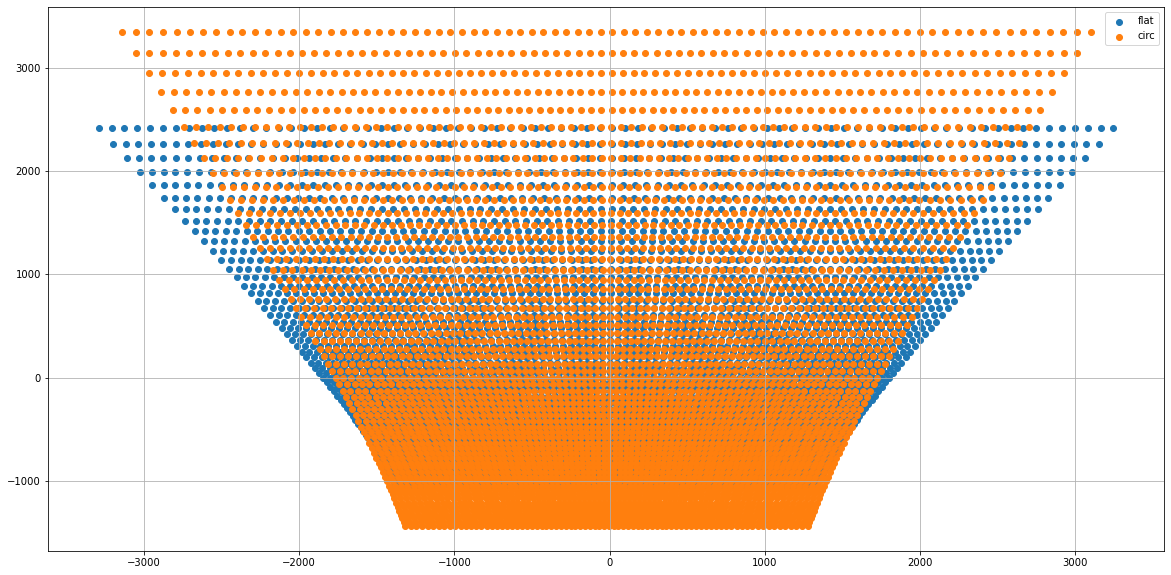

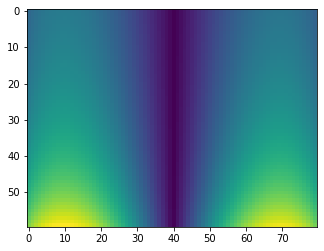

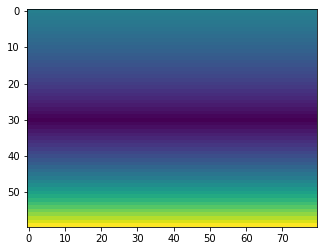

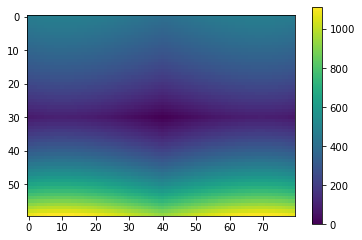

In [19]:
def _circle_perspective_reprojection(N_x, N_y, x_sun_, epsilon, height, 
                                   altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
       
#     # Project the Cross-Section plane in the Camera pLane in y-axis
#     def __y_axis(x_, y_, z_, height):
#         # Ciruclar Segment formula
#         rho_   = height - y_
#         kappa_ = rho_ + (x_**2)/rho_
#         s_     = .5*kappa_*np.arcsin(2.*x_/kappa_)
#         # compute y-axis absolute distance
#         y_hat_ = s_ - s_[0]
#         # Extend values to the frame dimensions grid
#         return np.tile(y_hat_, (N_x, 1)).T
    
    # Project the Cross-Section plane in the Camera pLane in y-axis
    def __y_axis(epsilon_, height, R, r):
        
        # Compute coefficients of the Troposphere and Earth Surface Chords equation
        def ___quadratic_coefficient(epsilon_, height, R, r):
            N = epsilon_.shape[0]
            # Compute quadratic formula coefficients for each elevation angle in a frame
            a_ = 1 + np.tan(epsilon_)**2
            b_ = 2. * r * np.tan(epsilon_)
            c_ = - np.ones(N) * height * (1. + 2.*r)
            #a_ = 1. + np.tan(epsilon_)**2
            #b_ = - 2. * r * np.tan(epsilon_)
            #c_ = - np.ones(N) * (R**2 - r**2)
            return np.stack((a_, b_, c_))
        # Solve Troposphere and Earth Surface Chords equation
        def ___solve_quadratic_formula(W_, e_, height):
            N = e_.shape[0]
            x_ = np.zeros(N)
            y_ = np.zeros(N)
            z_ = np.zeros(N)
            # Solve quadratic formula for each elevation angle in a frame
            for i in range(N):
                x_[i] = np.roots(W_[:, i])[1]
                y_[i] = x_[i] * np.tan(e_[i])
                z_[i] = y_[i] / np.sin(e_[i])
            return x_, y_, z_
    
        W_ = ___quadratic_coefficient(epsilon_, height, R, r)
        x_, y_, z_ = ___solve_quadratic_formula(W_, epsilon_, height)
        y_hat_ = r*np.arcsin(x_/r)
        y_hat_ = y_hat_ - y_hat_[0]
        return np.tile(y_hat_, (N_x, 1)).T, z_
    
    
   # Project the Cross-Section plane in the Camera pLane in x-axis
    def __x_axis(azimuth_, z_, height, R, r):
     # Compute coefficients of the Troposphere and Earth Surface Chords equation
        def ___quadratic_coefficient(azimuth_, z_, r_, height, R):
            N = z_.shape[0]
            M = azimuth_.shape[0]
            W_ = np.zeros((N, M, 3))
            # Compute quadratic formula coefficients for each elevation angle in a frame
            for i in range(N):
                for j in range(M):
                    W_[i,j,0] = -1. - np.tan(azimuth_[j])**2
                    W_[i,j,1] = 2.*r_[i] + 2.*z_[i]*np.tan(azimuth_[j])
                    W_[i,j,2] = - (z_[i]**2) * (np.tan(azimuth_[j])**2)
            return W_
        # Solve Troposphere and Earth Surface Chords equation
        def ___solve_quadratic_formula(W_, azimuth_, z_, r_, height, R):
            N = W_.shape[0]
            M = W_.shape[1]
            L_ = np.zeros((N, M))
            X_hat_ = np.zeros((N, M))
            # Solve quadratic formula for each elevation angle in a frame
            for i in range(N):
                for j in range(M):
                    L_[i,j] = np.roots(W_[i, j, :])[1]
                    X_hat_[i,j] = r_[i]*np.arcsin(( (z_[i] - L_[i,j]) * np.tan(azimuth_[j]))/r_[i])
            return X_hat_
        r_ = np.zeros((z_.shape[0]))
        for i in range(z_.shape[0]):
            r_[i] = ( (2.*R*height - height**2)/z_[i] ) + z_[i]
        W_ = ___quadratic_coefficient(azimuth_, z_, r_, height, R)
        X_hat_ = ___solve_quadratic_formula(W_, azimuth_, z_, r_, height, R)
        return X_hat_
    
    # Extend Elevation from Sun's Elevation Angle for each pixel
    def __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel):
        e_0  = epsilon + (N_y/2)*radians_per_pixel
        e_1  = epsilon - (N_y/2)*radians_per_pixel
        de   = (e_0 - e_1)/2.
        e_0_ = np.linspace(epsilon + de, epsilon + radians_per_pixel/2., int(N_y/2))
        e_1_ = np.linspace(epsilon - radians_per_pixel/2., epsilon - de, int(N_y/2))
        return np.concatenate((e_0_, e_1_), axis = 0)
    
    # Extend azimuth from camera FOV Angle for each pixel
    def __coordiantes_azimuth(N_x, radians_per_pixel):
        azimuth_ = np.linspace(0, N_x - 1, N_x)
        azimuth_ -= (N_x - 1)/2.
        azimuth_ *= radians_per_pixel
        return azimuth_
    
    # Elevation Angle from Degrees to Radiantes
    epsilon = np.radians(epsilon)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    # Sky-Parcel Geometric Constants
    r_earth = 6371000.     # Average Earth radius
    r = r_earth #+ altitude
    height = height - altitude
    R = r + height
    
    # Set the origen of the Coordinates plane in the Sun Position in the frame
    epsilon_ = __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel)
    azimuth_ = __coordiantes_azimuth(N_x, radians_per_pixel)

    # Get the axis distance and differential distances
    Y_, z_ = __y_axis(epsilon_, height, R, r) 
    X_ = __x_axis(azimuth_, z_, height, R, r)
    return X_, Y_

def _flat_perspective_reprojection(N_x, N_y, x_sun_, epsilon, height, 
                                   altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
    # Transform the Coordinates Plane to the Camera Plane
    def __camera_plane_coordinates(X_, Y_, pixel_size, focal_length):
        c = pixel_size/focal_length
        return X_ * c, Y_ * c
    # Project the Cross-Section plane in the Camera pLane
    def __cross_section_plane_coordinates(X_p_, Y_p_, epsilon_, height, N_x, N_y):
        z_    = height/np.sin(epsilon_)
        X_p_ *= np.tile(z_, (N_x, 1)).T
        Y_p_ *= np.tile(z_, (N_x, 1)).T
        return X_p_, Y_p_
    # Extend Elevation from Sun's Elevation Angle for each pixel
    def __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel):
        e_0  = epsilon + (N_y/2)*radians_per_pixel
        e_1  = epsilon - (N_y/2)*radians_per_pixel
        de   = (e_0 - e_1)/2.
        e_0_ = np.linspace(epsilon + de, epsilon + radians_per_pixel/2., int(N_y/2))
        e_1_ = np.linspace(epsilon - radians_per_pixel/2., epsilon - de, int(N_y/2))
        return np.concatenate((e_0_, e_1_), axis = 0)
    
    # Sky-Parcel Geometric Constants
    height  = height - altitude
    epsilon = np.radians(epsilon)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    
    # Sun's Position on the Cartenian Coordiantes
    X_, Y_ = np.meshgrid(np.linspace(0., N_x - 1., N_x), np.linspace(0., N_y - 1., N_y))
    X_ -= 39.5
    Y_ -= 29.5
    
    # Camera Plane Coordinates
    X_p_, Y_p_ = __camera_plane_coordinates(X_, Y_, pixel_size, focal_length)
    
    epsilon_ = __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel)
    # Cross-Section Plane Coordinates
    X_pp_, Y_pp_ = __cross_section_plane_coordinates(X_p_, Y_p_, epsilon_, height, N_x, N_y)
    # Stack together the Coordinates system and the incrementes in the coordinates grid
    return X_pp_, Y_pp_

epsilon = 40
height  = 4000
x_sun_ = [30, 40]
X_flat_, Y_flat_ = _flat_perspective_reprojection(N_x, N_y, x_sun_, epsilon, height)


X_circ_, Y_circ_ = _circle_perspective_reprojection(N_x, N_y, x_sun_, epsilon, height)

X_flat_ -= X_flat_[30, 40]
Y_flat_ -= Y_flat_[30, 40]


X_circ_ -= X_circ_[30, 40]
Y_circ_ -= Y_circ_[30, 40]

plt.figure(figsize = (20, 10))
plt.scatter(X_flat_.flatten(), Y_flat_.flatten(), label = 'flat')
plt.scatter(X_circ_.flatten(), Y_circ_.flatten(), label = 'circ')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.imshow(np.sqrt((X_flat_ - X_circ_)**2))
plt.show()

plt.figure()
plt.imshow(np.sqrt((Y_flat_ - Y_circ_)**2))
plt.show()

plt.figure()
plt.imshow(np.sqrt((Y_flat_ - Y_circ_)**2) + np.sqrt((X_flat_ - X_circ_)**2))
plt.colorbar()
plt.show()

[1.91571702 1.90440511 1.89309319 1.88178127 1.87046936 1.85915744
 1.84784553 1.83653361 1.8252217  1.81390978 1.80259787 1.79128595
 1.77997404 1.76866212 1.75735021 1.74603829 1.73472638 1.72341446
 1.71210255 1.70079063 1.68947872 1.6781668  1.66685489 1.65554297
 1.64423106 1.63291914 1.62160722 1.61029531 1.59898339 1.58767148
 1.57635956 1.56504765 1.55373573 1.54242382 1.5311119  1.51979999
 1.50848807 1.49717616 1.48586424 1.47455233 1.46324041 1.4519285
 1.44061658 1.42930467 1.41799275 1.40668084 1.39536892 1.38405701
 1.37274509 1.36143317 1.35012126 1.33880934 1.32749743 1.31618551
 1.3048736  1.29356168 1.28224977 1.27093785 1.25962594 1.24831402
 1.23700211]
[1.21782658 1.20651466 1.19520275 1.18389083 1.17257892 1.161267
 1.14995509 1.13864317 1.12733126 1.11601934 1.10470743 1.09339551
 1.08208359 1.07077168 1.05945976 1.04814785 1.03683593 1.02552402
 1.0142121  1.00290019 0.99158827 0.98027636 0.96896444 0.95765253
 0.94634061 0.9350287  0.92371678 0.91240487 0.90109

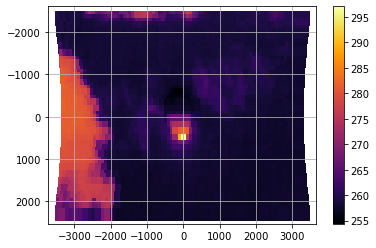

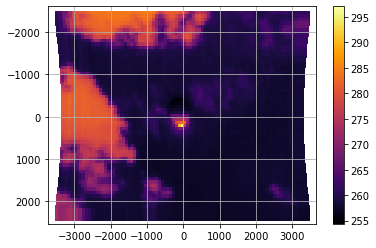

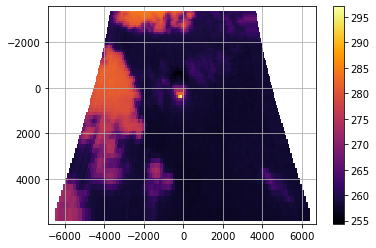

In [328]:
el, I_segm_2_, H_2_, K_2_, I_norm_2_ = dataset_[3]
    
# Camera Parameters
epsilon = 90
azimuth = 100
height  = np.mean(H_2_[I_segm_2_])
x_sun_  = [30, 40]

XYZ_90_, dXYZ_90_, _, _, _ = _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_, 
                                                    epsilon, azimuth, latitude, longitude, height)
epsilon = el
XYZ_, dXYZ_, _, _, _, = _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_, 
                                                    epsilon, azimuth, latitude, longitude, height)

I_ = K_2_.reshape(XYZ_.shape[0]*XYZ_.shape[1])
print(XYZ_90_.shape, XYZ_.shape)

X_90_ = XYZ_90_[..., :2].reshape(XYZ_90_.shape[0]*XYZ_90_.shape[1], 2)
X_    = XYZ_[..., :2].reshape(XYZ_.shape[0]*XYZ_.shape[1], 2)
print(X_90_.shape, X_.shape, I_.shape)   
Z_ = griddata(X_, I_, (X_90_[:, 0], X_90_[:, 1]), method = 'nearest').reshape(XYZ_.shape[0], XYZ_.shape[1])
print(Z_.shape)

plt.figure()
plt.scatter(X_90_[:, 0], X_90_[:, 1], c = Z_, s = 125, marker = 's', cmap = 'inferno')
plt.colorbar()
plt.grid()
plt.gca().invert_yaxis()
plt.show()

plt.figure()
plt.scatter(X_90_[:, 0], X_90_[:, 1], c = I_, s = 125, marker = 's', cmap = 'inferno')
plt.colorbar()
plt.grid()
plt.gca().invert_yaxis()
plt.show()

plt.figure()
plt.scatter(X_[:, 0], X_[:, 1], c = I_, s = 125, marker = 's', cmap = 'inferno')
plt.colorbar()
plt.grid()
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize = (20, 10))
plt.title(r'Great Circle Atmosphere Cross-Section at ${}$ [km]'.format(height/1000), fontsize = 45)
plt.scatter(X_[:, 0], X_[:, 1], c = I_, s = 125, marker = 's', cmap = 'inferno')
plt.legend(fontsize = 35, loc = 'upper right')
plt.grid()
plt.gca().invert_yaxis()
plt.xlabel('x-axis [m]', fontsize = 35)
plt.ylabel('y-axis [m]', fontsize = 35)
plt.xticks(fontsize = 35)
plt.yticks(fontsize = 35)
plt.show()

In [160]:
# Camera Parameters
epsilon = 90
azimuth = 100
height = 12500
x_sun_ = [30, 40]

XYZ_v5_, dXYZ_, _, _, _ = _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_, 
                                                         epsilon, azimuth, latitude, longitude, height)

XYZ_v0_, dXYZ_, x_ = _perspective_transformation_v0(X_, Y_, N_x, N_y, x_sun_, epsilon, height)

print(XYZ_v5_[..., 0].min(), XYZ_v5_[..., 0].max(), XYZ_v5_[..., 1].min(), XYZ_v5_[..., 1].max())
print(XYZ_v0_[..., 0].min(), XYZ_v0_[..., 0].max(), XYZ_v0_[..., 1].min(), XYZ_v0_[..., 1].max())

dx_v5 = XYZ_v5_[..., 0].min() + XYZ_v5_[..., 0].max()
dy_v5 = XYZ_v5_[..., 1].min() + XYZ_v5_[..., 1].max()
print(dx_v5, dy_v5)
dx_v0 = XYZ_v0_[..., 0].min() + XYZ_v0_[..., 0].max()
dy_v0 = XYZ_v0_[..., 1].min() + XYZ_v0_[..., 1].max()
print(dx_v0, dy_v0)
plt.figure(figsize = (20, 10))
plt.scatter(XYZ_v5_[..., 0].flatten() - dx_v5/2., XYZ_v5_[..., 1].flatten() - dx_v5/2., s = 10, label = 'circle')
plt.scatter(XYZ_v0_[..., 0].flatten() - dx_v0/2., XYZ_v0_[..., 1].flatten() - dy_v0/2, s = 10, label = 'flat')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize = (20, 10))
#plt.plot(XYZ_v5_[..., 1].flatten(), '.')
#plt.plot(XYZ_v0_[..., 1].flatten(), '.')
plt.plot(XYZ_v5_[..., 1] - XYZ_v0_[..., 1].flatten(), '.')
plt.show()


E_x_ = (XYZ_v5_[..., 0] - XYZ_v0_[..., 0])**2
E_y_ = (XYZ_v5_[..., 1] - XYZ_v0_[..., 1])**2

plt.figure()
plt.imshow(np.sqrt(E_x_))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.sqrt(E_y_))
plt.colorbar()
plt.show()

[1.91571702 1.90440511 1.89309319 1.88178127 1.87046936 1.85915744
 1.84784553 1.83653361 1.8252217  1.81390978 1.80259787 1.79128595
 1.77997404 1.76866212 1.75735021 1.74603829 1.73472638 1.72341446
 1.71210255 1.70079063 1.68947872 1.6781668  1.66685489 1.65554297
 1.64423106 1.63291914 1.62160722 1.61029531 1.59898339 1.58767148
 1.57635956 1.56504765 1.55373573 1.54242382 1.5311119  1.51979999
 1.50848807 1.49717616 1.48586424 1.47455233 1.46324041 1.4519285
 1.44061658 1.42930467 1.41799275 1.40668084 1.39536892 1.38405701
 1.37274509 1.36143317 1.35012126 1.33880934 1.32749743 1.31618551
 1.3048736  1.29356168 1.28224977 1.27093785 1.25962594 1.24831402
 1.23700211]
[1.91024808 1.89893302 1.88761796 1.8763029  1.86498784 1.85367278
 1.84235773 1.83104267 1.81972761 1.80841255 1.79709749 1.78578243
 1.77446738 1.76315232 1.75183726 1.7405222  1.72920714 1.71789208
 1.70657703 1.69526197 1.68394691 1.67263185 1.66131679 1.65000173
 1.63868668 1.62737162 1.61605656 1.6047415  1.593

ValueError: operands could not be broadcast together with shapes (4800,2) (60,80) (4800,2) 

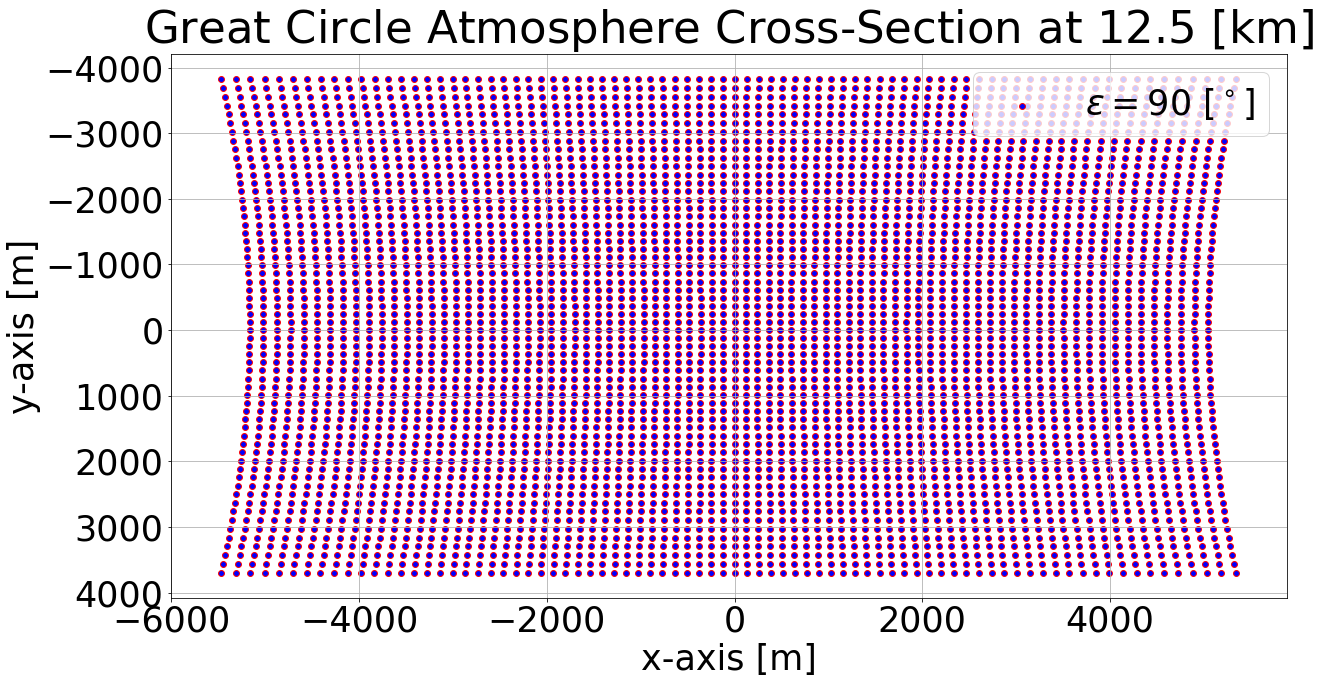

In [92]:
# Camera Parameters
epsilon = 90
azimuth = 100
height  = 12500.
x_sun_  = [30, 40]

XYZ_v5_, dXYZ_, _, _, _, XY_interp_v5_ = _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_, 
                                                         epsilon, azimuth, latitude, longitude, height)

plt.figure(figsize = (20, 10))
plt.title(r'Great Circle Atmosphere Cross-Section at ${}$ [km]'.format(height/1000), fontsize = 45)
plt.scatter(XYZ_v5_[..., 0].flatten(), XYZ_v5_[..., 1].flatten(), s = 35, 
            marker = 'o', facecolors = 'b', edgecolors = 'r', 
            label = r'$\varepsilon = 90 \ [^\circ]$')
plt.legend(fontsize = 35, loc = 'upper right')
plt.grid()
plt.gca().invert_yaxis()
plt.xlabel('x-axis [m]', fontsize = 35)
plt.ylabel('y-axis [m]', fontsize = 35)
plt.xticks(fontsize = 35)
plt.yticks(fontsize = 35)
plt.show()

# epsilon = 60

# XYZ_v5_, dXYZ_, _, _, _, XY_interp_v5_ = _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_, 
#                                                          epsilon, azimuth, latitude, longitude, height)

# plt.figure(figsize = (20, 10))
# plt.title(r'Great Circle Atmosphere Cross-Section at ${}$ [km]'.format(height/1000), fontsize = 45)
# plt.scatter(XYZ_v5_[..., 0].flatten(), XYZ_v5_[..., 1].flatten(), s = 35, marker = 'o', facecolors = 'blue', 
#             label = r'$ \varepsilon = {} \ [^\circ]$ '.format(epsilon))
# plt.scatter(XYZ_v5_[XY_interp_v5_[1], 0].flatten(), XYZ_v5_[XY_interp_v5_[1], 1].flatten(), s = 35, 
#             marker = 'o', facecolors = 'none', edgecolors = 'r', 
#             label = r'$\varepsilon = 90 \ [^\circ]$')
# plt.legend(fontsize = 35, loc = 'upper right')
# plt.grid()
# plt.gca().invert_yaxis()
# plt.xlabel('x-axis [m]', fontsize = 35)
# plt.ylabel('y-axis [m]', fontsize = 35)
# plt.xticks(fontsize = 35)
# plt.yticks(fontsize = 35)
# plt.show()

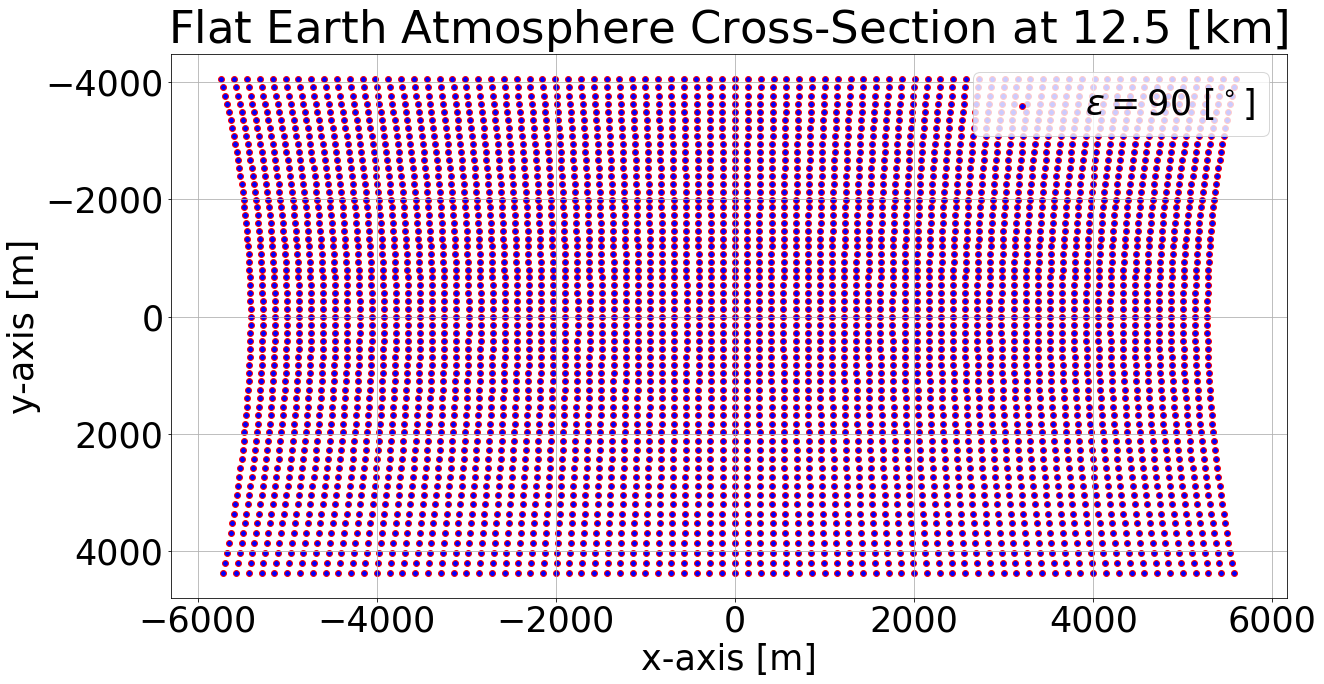

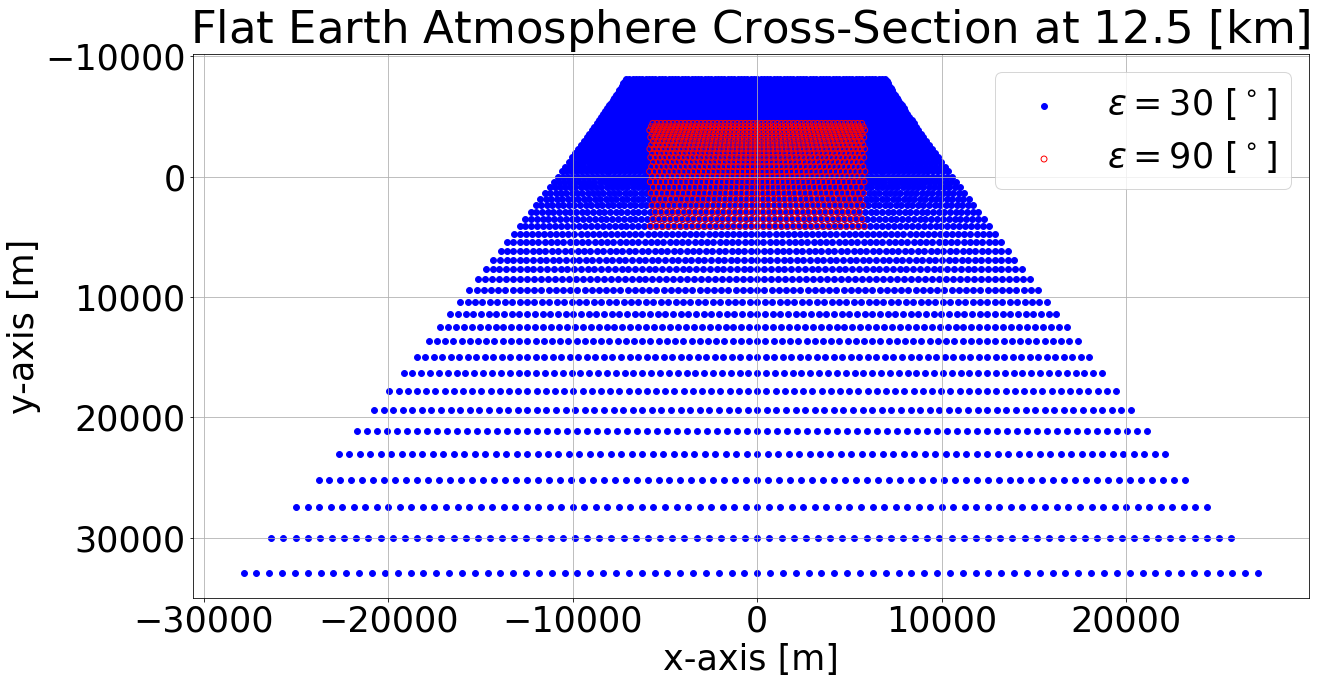

In [38]:
# Camera Parameters
height = 12500
x_sun_ = [30, 40]

epsilon = 90
XYZ_v0_, dXYZ_, x_, XY_interp_v0_ = _perspective_transformation_v0(X_, Y_, N_x, N_y, x_sun_, epsilon, height)

plt.figure(figsize = (20, 10))
plt.title(r'Flat Earth Atmosphere Cross-Section at ${}$ [km]'.format(height/1000), fontsize = 45)
plt.scatter(XYZ_v0_[..., 0].flatten(), XYZ_v0_[..., 1].flatten(), s = 35, marker = 'o', 
            facecolors = 'b', edgecolors = 'r',
            label = r'$\varepsilon = 90 \ [^\circ]$')
plt.legend(fontsize = 35, loc = 'upper right')
plt.grid()
plt.gca().invert_yaxis()
plt.xlabel('x-axis [m]', fontsize = 35)
plt.ylabel('y-axis [m]', fontsize = 35)
plt.xticks(fontsize = 35)
plt.yticks(fontsize = 35)
plt.show()

epsilon = 30

XYZ_v0_, dXYZ_, x_, XY_interp_v0_ = _perspective_transformation_v0(X_, Y_, N_x, N_y, x_sun_, epsilon, height)

plt.figure(figsize = (20, 10))
plt.title(r'Flat Earth Atmosphere Cross-Section at ${}$ [km]'.format(height/1000), fontsize = 45)
plt.scatter(XYZ_v0_[..., 0].flatten(), XYZ_v0_[..., 1].flatten(), s = 35, marker = 'o', facecolors = 'blue', 
            label = r'$ \varepsilon = {} \ [^\circ]$'.format(epsilon))
plt.scatter(XYZ_v0_[XY_interp_v0_[1], 0].flatten(), XYZ_v0_[XY_interp_v0_[1], 1].flatten(), s = 35, 
            marker = 'o', facecolors = 'none', edgecolors = 'r', 
            label = r'$\varepsilon = 90 \ [^\circ]$')
plt.legend(fontsize = 35, loc = 'upper right')
plt.grid()
plt.gca().invert_yaxis()
plt.xlabel('x-axis [m]', fontsize = 35)
plt.ylabel('y-axis [m]', fontsize = 35)
plt.xticks(fontsize = 35)
plt.yticks(fontsize = 35)
plt.show()

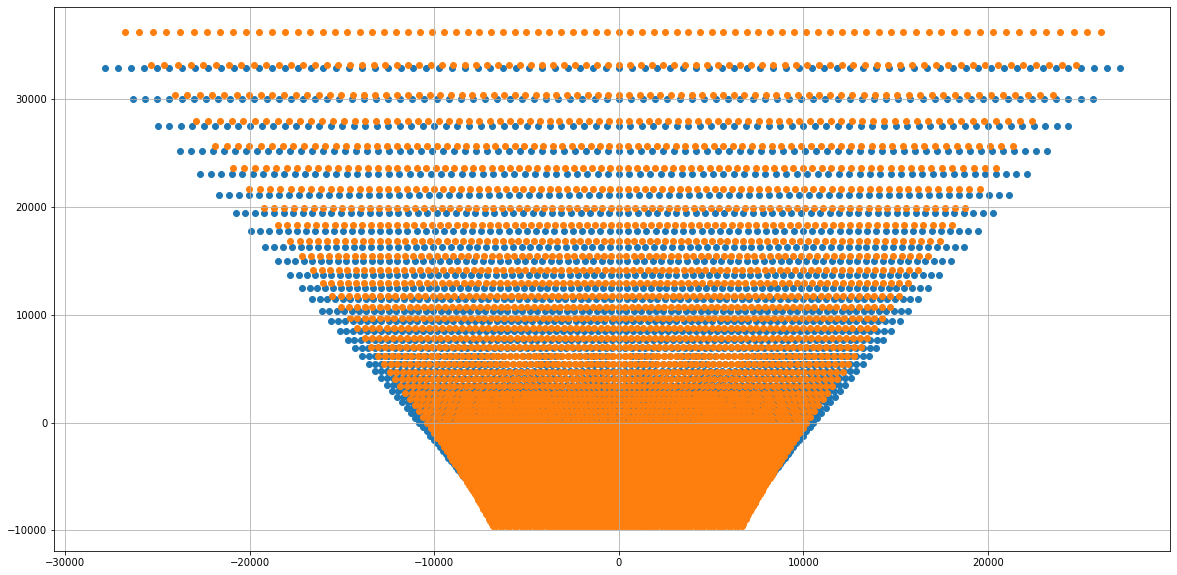

In [33]:
# Camera Parameters
epsilon = 30
azimuth = 100
height  = 12500.


x_sun_  = [30, 40]


XYZ_v5_, dXYZ_v5_, _, _, _, XY_interp_v5_ = _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_, 
                                                         epsilon, azimuth, latitude, longitude, height)

x_sun_  = [30, 40]

XYZ_v0_, dXYZ_, x_, XY_interp_v0_ = _perspective_transformation_v0(X_, Y_, N_x, N_y, x_sun_, epsilon, height)



plt.figure(figsize = (20, 10))
plt.scatter(XYZ_v0_[..., 0].flatten(), XYZ_v0_[..., 1].flatten())
plt.scatter(XYZ_v5_[..., 0].flatten(), XYZ_v5_[..., 1].flatten())
plt.grid()
plt.show()

### Compute Error Between Geometric Transformations

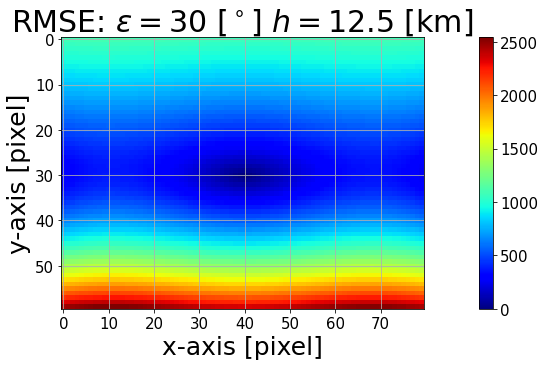

In [36]:
# Camera Parameters
epsilon = 30
height  = 12500
x_sun_  = [30, 40]

XYZ_5_, dXYZ_5_, _, _, _, XY_interp_5_ = _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_,
                                                                        epsilon, azimuth, latitude, 
                                                                        longitude, height)

XYZ_0_, dXYZ_0_, _, XY_interp_0_ = _perspective_transformation_v0(X_, Y_, N_x, N_y, x_sun_, epsilon, height)

E_x_ = (XYZ_5_[..., 0] - XYZ_0_[..., 0])**2
E_y_ = (XYZ_5_[..., 1] - XYZ_0_[..., 1])**2

plt.figure(figsize = (20, 5))
plt.title(r'RMSE: $ \varepsilon = {} \ [^\circ]$ $h = {}$ [km]'.format(epsilon, height/1000), 
          fontsize = 30)
plt.imshow(np.sqrt((E_x_ + E_y_)/2.), cmap = 'jet')
plt.xlabel('x-axis [pixel]', fontsize = 25)
plt.ylabel('y-axis [pixel]', fontsize = 25)
plt.colorbar().ax.tick_params(labelsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()
plt.show()

# Projection of the Camera Frame on the Earth Surfaces

612 922
(268, 400, 4)


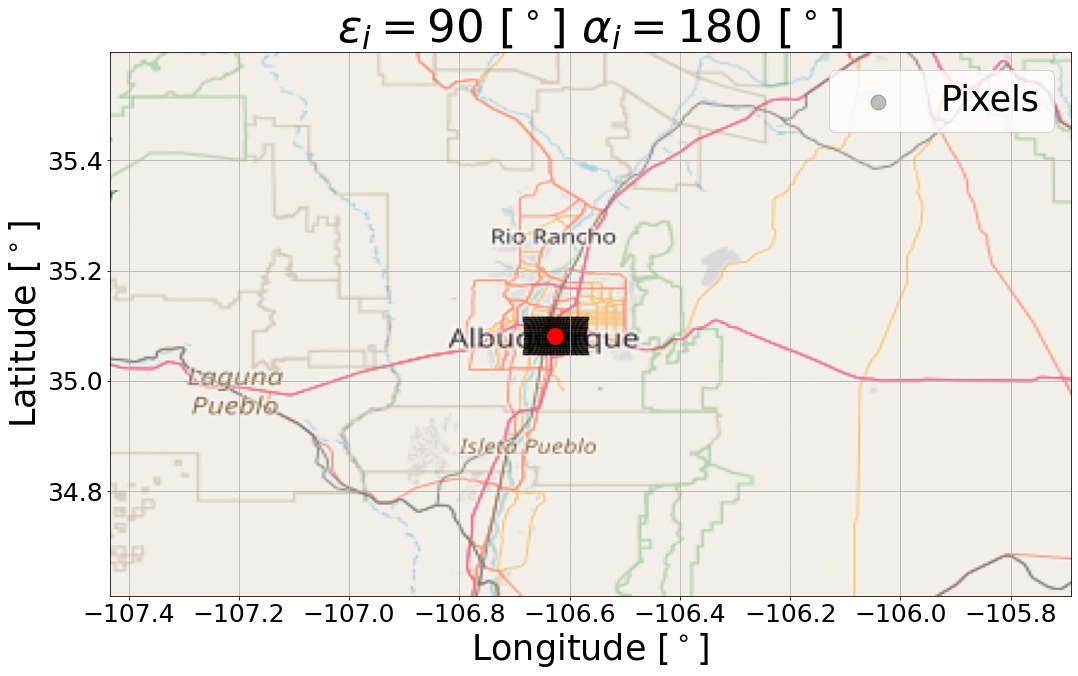

In [21]:
def _plot_map(XY_, M_, longitude, latitude, epsilon, azimuth, height, lim_):
    
    #limits_ = (-108.660, -104.464, 33.966, 36.240)

    limits_ = (-107.434, -105.69, 34.61, 35.596)

    M_ = M_[172:-172, 261:-261, :]
    print(M_.shape)

    fig, ax = plt.subplots(figsize = (20, 10))
    #epsilon = 30
    ax.set_title(r'$\varepsilon_i = {} \ [^\circ]$ $\alpha_i = {} \ [^\circ]$'.format(
                 epsilon, azimuth), fontsize = 45)
        
    ax.scatter(XY_[..., 0].flatten(), XY_[..., 1].flatten(), alpha = .25, s = 1., 
               c = 'k', label = r'Pixels')
    ax.scatter(longitude, latitude, zorder = 1, s = 250, alpha = 1., c = 'r', marker = 'o')

    
    ax.set_xlim(limits_[0], limits_[1])
    ax.set_ylim(limits_[2], limits_[3])
    ax.legend(fontsize = 35, markerscale = 15,loc = 'upper right')
    
    plt.imshow(M_, extent = limits_)
    ax.set_xlabel('Longitude $[^\circ]$', fontsize = 35)
    ax.set_ylabel('Latitude $[^\circ]$', fontsize = 35)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 25) 
    ax.grid()
    plt.show()


# Load-up New Mexico Map
map_ = plt.imread(r'/Users/Guille/Desktop/prespective_transformation/data/map.png')
n_y, n_x, _ = map_.shape
limits_ = (-108.660, -104.464, 33.966, 36.240)
print(n_y, n_x)

# Camera Parameters
epsilon = 90
azimuth = 180
height  = 12500.
x_sun_ = [30, 40]

XYZ_, dXYZ_, XY_, XY_p_, XY_pp_, _ = _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_, 
                                                                        epsilon, azimuth, latitude, 
                                                                        longitude, height)
_plot_map(XY_pp_, map_, longitude, latitude, epsilon, azimuth, height, limits_)

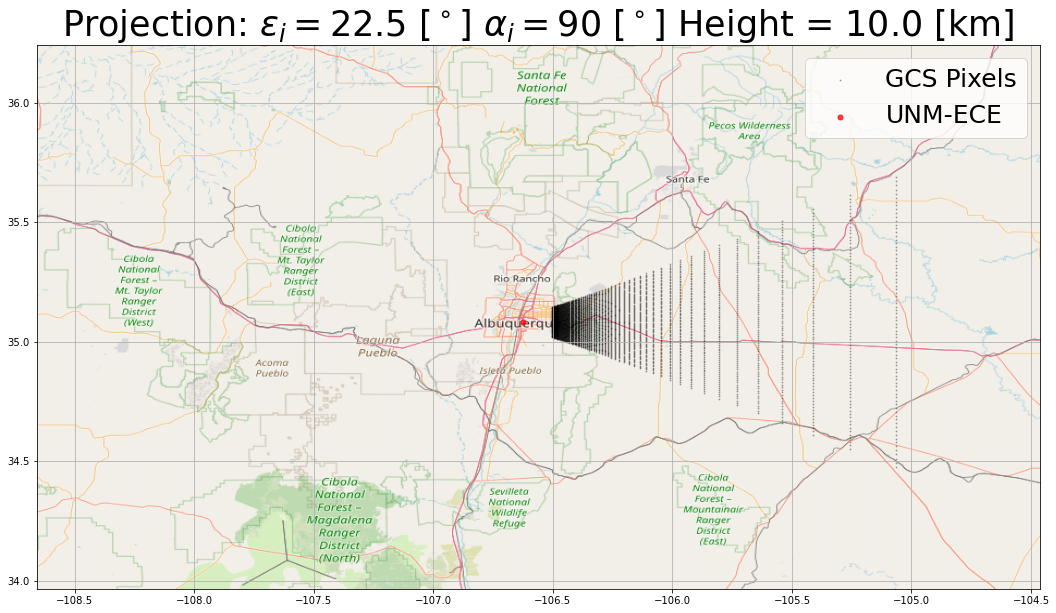

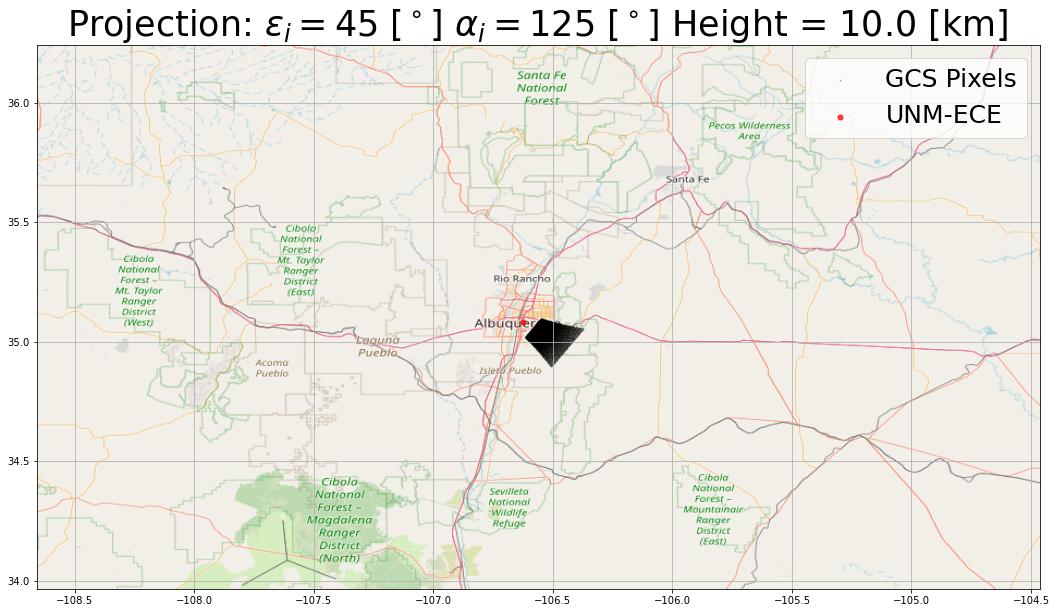

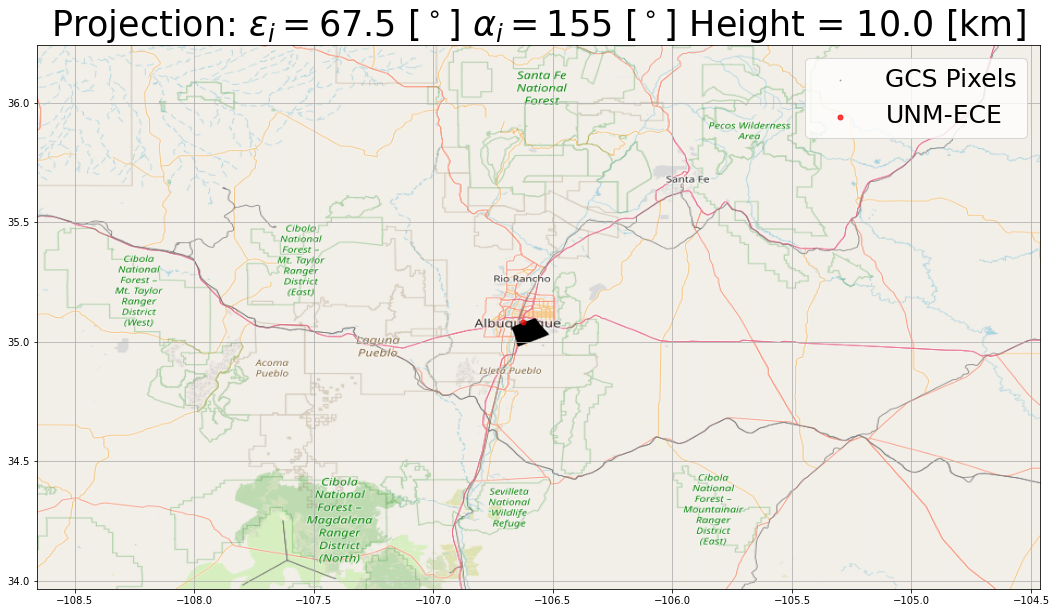

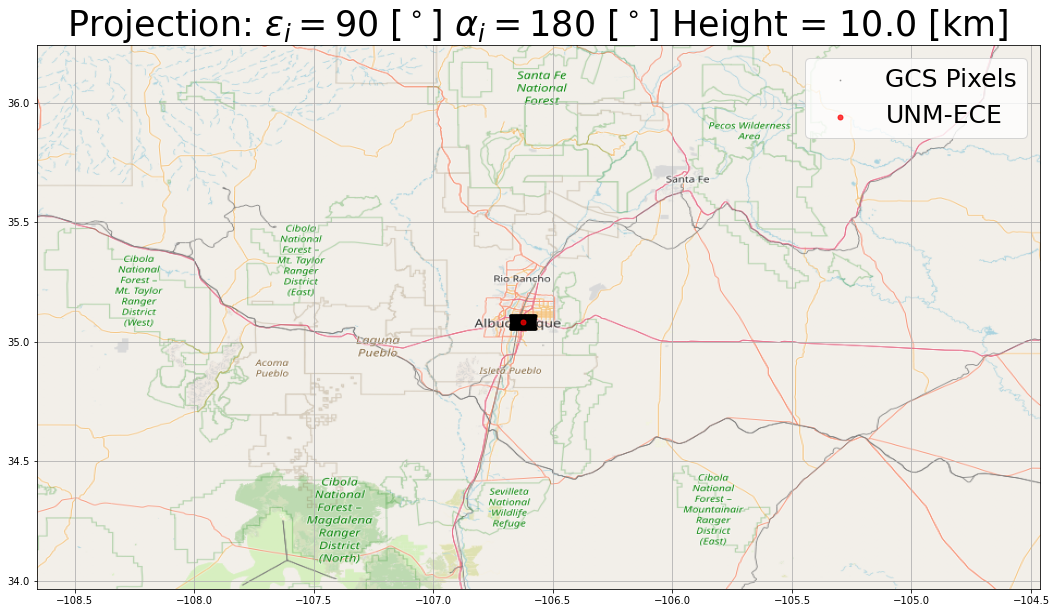

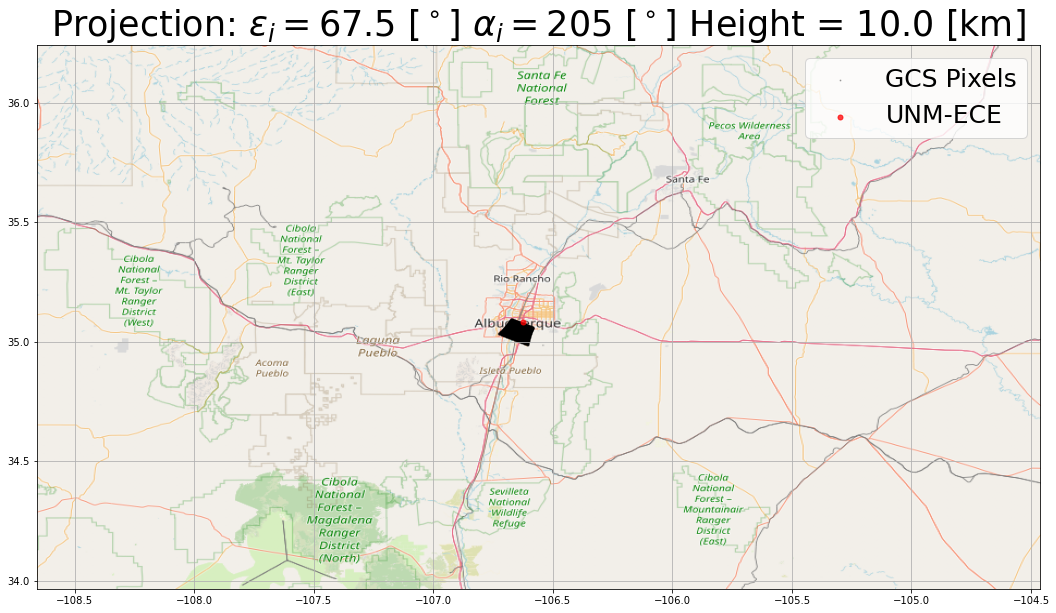

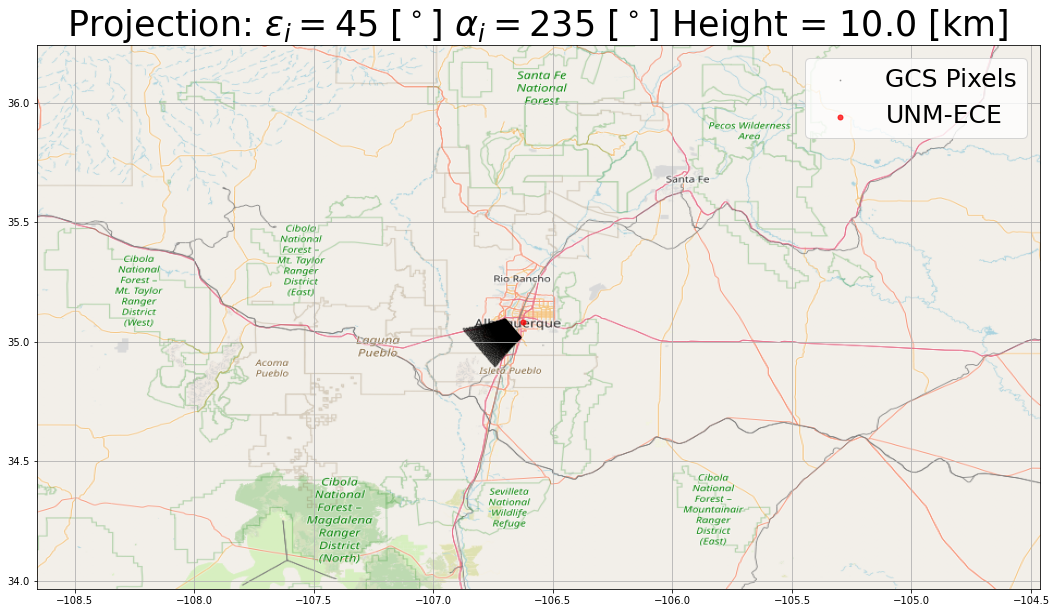

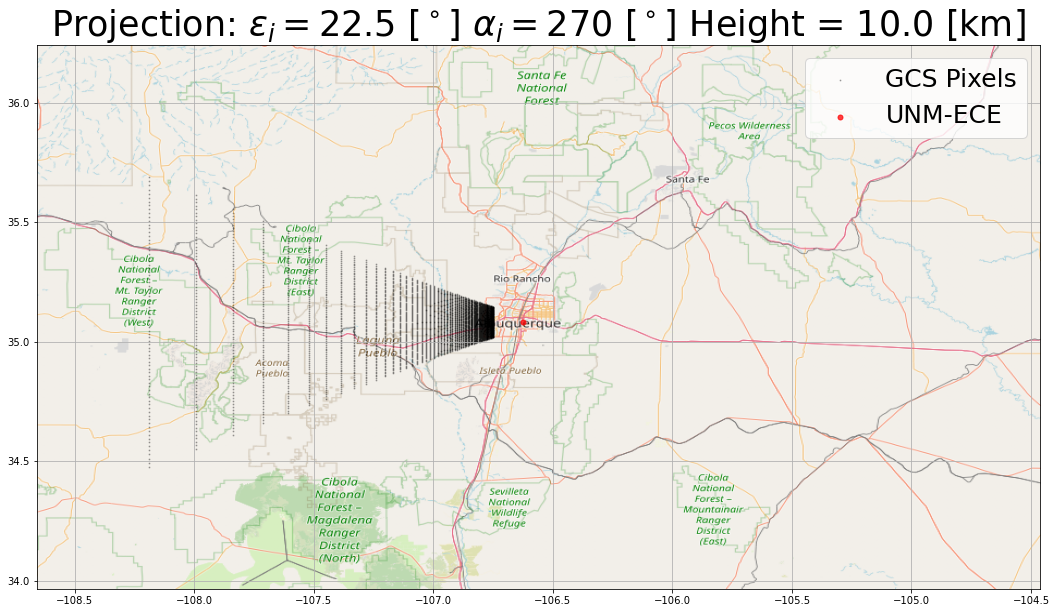

In [103]:
def _plot_map(XY_, M_, longitude, latitude, epsilon, azimuth, height, lim_):
    fig, ax = plt.subplots(figsize = (20, 10))
    ax.scatter(XY_[..., 0].flatten(), XY_[..., 1].flatten(), alpha = .25, s = 1., 
               c = 'k', label = r'GCS Pixels')
    ax.scatter(longitude, latitude, zorder = 1, s = 25, alpha = .75, c = 'r', label = r'UNM-ECE')
    ax.set_title(r'Projection: $\varepsilon_i = {} \ [^\circ]$ $\alpha_i = {} \ [^\circ]$ Height = {} [km]'.format(
                epsilon, azimuth, height/1000.), fontsize = 35)
    
    ax.set_xlim(lim_[0], lim_[1])
    ax.set_ylim(lim_[2], lim_[3])
    ax.imshow(M_, zorder = 0, extent = lim_, aspect= 'equal')
    ax.legend(fontsize = 25, loc = 'upper right')
    ax.grid()
    plt.show()

# Load-up New Mexico Map
map_ = plt.imread(r'/Users/Guille/Desktop/prespective_transformation/data/map.png')
    
# Camera Parameters
epsilon = 45
azimuth = 100
height  = 10000.
x_sun_ = [30, 40]

for epsilon, azimuth in zip([22.5, 45, 67.5, 90, 67.5,45, 22.5], [90, 125, 155, 180, 205, 235, 270]):
    XYZ_, dXYZ_, XY_, XY_p_, XY_pp_, _ = _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_, 
                                                                        epsilon, azimuth, latitude, 
                                                                        longitude, height)
    _plot_map(XY_pp_, map_, longitude, latitude, epsilon, azimuth, height, 
              lim_ = (-108.660, -104.464, 33.966, 36.240))